In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [14]:
# GymのPendulum環境を作成
dt = 0.05
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [52]:
def _actor_initial_weight(actor):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.01]])
    
    K = lqr(A,B,Q,R)[0]
    
    weights = []
    for i in range(len(actor.layers)):
        if i < 2:
            continue
        else:
            w, b = actor.layers[i].get_weights()
            w, b = np.zeros_like(w), np.zeros_like(b)
            if i == 2:
                w[0][0] = K[0]
                w[1][0] = K[1]
            elif i == 4:
                w[0][0] = 1
                w[1][1] = 1
            else:
                w[0][0] = 1
            weights.append(w)
            weights.append(b)
    return weights

def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="single_lin_relu")(x)
    x = Dense(16, activation="single_lin_relu_sig")(x)
    x = Dense(2, activation="linear")(x)
    actor = Model(inputs=action_input, outputs=x)
    actor.summary()
    # actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [53]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [54]:
#safe learning
l = 0.5
step = 300000
control_interval = 5
episode_step = int(200 * 0.05 / (dt * control_interval)) # 入力が加えられる回数を200(dt=0.05)にする
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, action_repetition=control_interval)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 1, 2)              0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 2)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_56 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 34        
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________
Training for 300000 steps ...
Interval 1 (0 steps performed)
 1481/10000 [===>..........................] - ETA: 1:25 - reward: 5.9313done, took

In [56]:
a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
a.test(env, l=l, visualize=0, nb_max_episode_steps=episode_step, action_repetition=control_interval)

Testing for 1 episodes ...
Episode 1: reward: 91.745, steps: 40


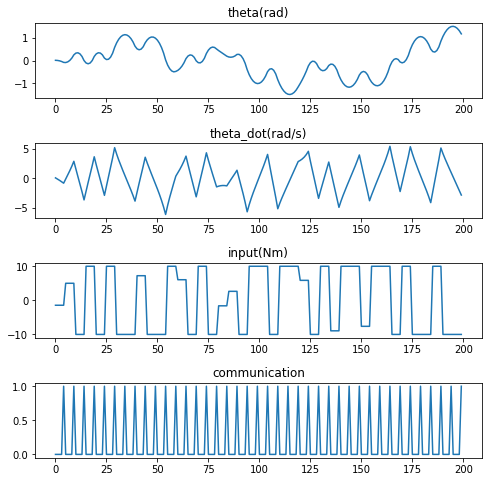

In [44]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'communication'] 
history = a.data_log[0]
x_axis = range(history.shape[0])
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(history.shape[1]):
    data = history[:,i]
    plt.subplot(history.shape[1],1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [55]:
print(a.layers[3].get_weights()[0])

[[ 0.02958213  0.21332833  0.13868217 -0.48837566 -0.00645147  0.39816025
   0.53031117 -0.4110441   0.33407688  0.9374839   0.3172646   0.03913396
   0.30912808 -0.06082741  0.4514995  -0.27852088]
 [-0.27444983  0.9890058   0.21559061 -0.15213554  0.24333858  0.52809006
   0.6513397   0.1220369   0.7318103   0.33322528  0.24824044 -0.24108991
  -0.45000327 -0.027815    0.1513503   0.518184  ]
 [-0.17706321  0.5186001   0.25175285  0.47104013  0.572521   -0.13185425
   0.5511087   0.08311659  0.5465442   0.508358    0.18011142  0.31793594
   0.17703152  0.00353874  0.32430947  0.3648325 ]
 [-0.41864228  0.21341625  0.35040763  0.5355573   0.5066144   0.52998966
   0.6611794  -0.1947842   0.26050743  0.15379348 -0.11961536  0.02842532
  -0.1561651  -0.1737425   0.21120252  0.2729603 ]
 [-0.19434379 -0.12715177  0.41899976 -0.277474    0.01010244  0.43953335
  -0.06234412  0.3481789   0.18057759  0.25515425  0.30678666 -0.14476499
  -0.39447632 -0.4504282  -0.2749406  -0.11110549]
 [ 0.